In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

# Table of content
- [Data Preprocessing](#data-preprocessing)
    - [Quarterly GDP-Country Date (OECD)](#gdp-oced)
    - [Quarterly Income-Based Real GDP (BEA)](#real-gdp-bea)
- [Merge Data](#merge)
- [Exploratory Data Analysis](#eda)
- [Time Series Models](#time-series-model)
    - [AR Model](#ar)
    - [SARIMAX](#sarimax)
    - [Holt-Winter's Method](#holt-winter)
- [Conclusion](#conclusion)
- [Resource](#resource)

# Data Preprocessing<a name="data-preprocessing"></a> 

The Organisation for Economic Co-operation and Development (OECD) has more open historical data than the US government. The data can track back to 1949, but I was not sure of its accuracy. For verification, I compare the data with the real gross domestic product from the Bureau of Economic Analysis data. After approving the two data frames show the same result, I can use the real GDP from 2019-01-01 to calculate all the real GDP data back to 1949.

### Quarterly GDP-Country Date (OECD) <a name="gdp-oced"></a>

The data was the quarterly real GDP of all countries between 1949 to 2019 and was from the Organisation for Economic Co-operation and Development. Before merging the data, I did some pre-process as the following steps. First of all, I just wanted the USA data, so I created a filter to help me filter out the location is not the USA. The second step, I wanted the time and value columns only, so I removed the rest of the column to avoid noise. The third steps, I wanted the time column to be comparable, thus; I change the type to date-time. The fourth step is to check the annual GDP. Therefore, I created a new column call annually percentage change and draw the line plots to see the trend.

In [2]:
# Load the data
gdp_countries = pd.read_csv('./data/quarterly_gdp_countries.csv')

In [3]:
# Check the head of the data. The unit is Millions of current dollars.
gdp_countries.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q2,4.310098,NaN
1,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q3,-0.774027,NaN
2,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q4,0.729033,NaN
3,KOR,QGDP,TOT,PC_CHGPP,Q,1961-Q1,3.033988,NaN
4,KOR,QGDP,TOT,PC_CHGPP,Q,1961-Q2,3.905591,NaN


In [4]:
# Select the Location to be USA  
mask_usa = gdp_countries['LOCATION'] == 'USA'
gdp = gdp_countries[mask_usa]

In [5]:
# Check the shape of gdp
gdp.shape

(288, 8)

In [6]:
# Check the type of each column
gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 3412 to 3699
Data columns (total 8 columns):
LOCATION      288 non-null object
INDICATOR     288 non-null object
SUBJECT       288 non-null object
MEASURE       288 non-null object
FREQUENCY     288 non-null object
TIME          288 non-null object
Value         288 non-null float64
Flag Codes    0 non-null object
dtypes: float64(1), object(7)
memory usage: 20.2+ KB


In [7]:
# Set the dataframe have only Time and value
gdp = gdp[['TIME','Value']]

In [8]:
# change the type of time column to be datetime
gdp['TIME'] = pd.to_datetime(gdp["TIME"])

In [9]:
# Rename the columns to percentage change.
gdp.columns = ['time', 'pct_change']

In [10]:
gdp['annually \npct_change'] = gdp['pct_change'].rolling(4).mean()

In [11]:
gdp.head()

,time,pct_change,annually pct_change
3412,1947-04-01,-0.266691,NaN
3413,1947-07-01,-0.206496,NaN
3414,1947-10-01,1.564208,NaN
3415,1948-01-01,1.504256,0.648819
3416,1948-04-01,1.650658,1.128157


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


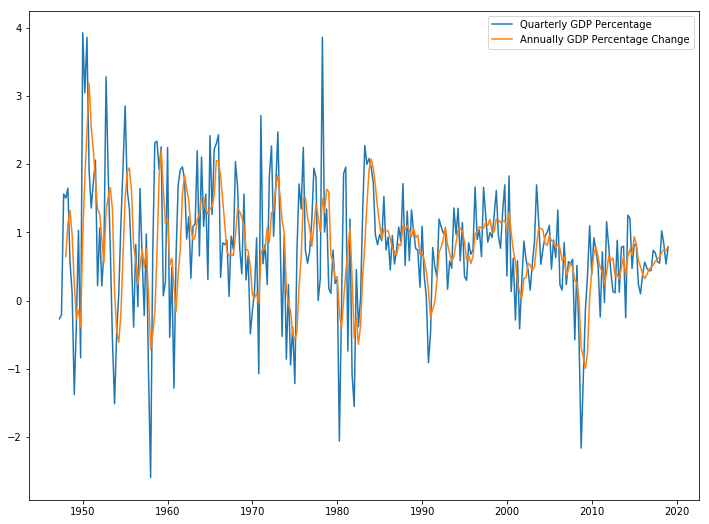

In [12]:
# Visualize the GDP change quarterly and annually
plt.figure(figsize=(12,9))
plt.plot(gdp['time'],gdp['pct_change'], label='Quarterly GDP Percentage')
plt.plot(gdp['time'],gdp['annually \npct_change'], label='Annually GDP Percentage Change')
plt.legend();

- The percentage line plot show 3 significant drop of GDP over 2% in 1958, 1980, and 2009. 

## Quarterly Income-Based Real GDP (BEA) <a name='real-gdp-bea'></a>

In [13]:
# Import the quarterly industry-based gdp data.
gdp_in = pd.read_excel('./data/real_gdp_quarterly_2017_2019.xls')

In [14]:
gdp_in.head(3)

,"Table 1.1.3. Real Gross Domestic Product, Quantity Indexes",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,"[Index numbers, 2012=100] Seasonally adjusted",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bureau of Economic Analysis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Last Revised on: April 26, 2019 - Next Release...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Cause I just want the GDP of each quarter to compare the percentage change,
# so I will keep only the GDP row.
gdp_in = gdp_in[6:7]

In [16]:
gdp_in

,"Table 1.1.3. Real Gross Domestic Product, Quantity Indexes",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
6,1,Gross domestic product,110.286,111.102,111.878,112.513,113.132,114.29,115.237,115.856,116.764


In [17]:
# Check the column name
gdp_in.columns[0]

'Table 1.1.3. Real Gross Domestic Product, Quantity Indexes'

In [18]:
# Drop the first column, because it is just Line index of industry
gdp_in = gdp_in.drop(columns = ['Table 1.1.3. Real Gross Domestic Product, Quantity Indexes'])


In [19]:
# Convert the column with row.
gdp_int = gdp_in.T

In [20]:
# Drop the first row. 
gdp_int = gdp_int[1:]

In [21]:
# Rename the column. 
gdp_int.columns = ['gdp_quarterly']

In [22]:
# Add a new column to indicate the time  
gdp_int['time'] = ['2017/01/01','2017/04/01','2017/07/01','2017/10/01',
                   '2018/01/01','2018/04/01','2018/07/01','2018/10/01',
                   '2019/01/01']

In [23]:
# Change the type of time column to datetime
gdp_int['time'] = pd.to_datetime(gdp_int["time"])

In [24]:
# Add new column to see the percentage change and time 100% to change the unit
gdp_int['quarterly_pct_change'] = gdp_int['gdp_quarterly'].pct_change()

In [25]:
gdp_int.head()

,gdp_quarterly,time,quarterly_pct_change
Unnamed: 2,110.286,2017-01-01,NaN
Unnamed: 3,111.102,2017-04-01,0.007399
Unnamed: 4,111.878,2017-07-01,0.006985
Unnamed: 5,112.513,2017-10-01,0.005676
Unnamed: 6,113.132,2018-01-01,0.005502


# Merge Data <a name='merge'></a>

In [26]:
# Merge two gdp data frame by left to keep all data in gdp_indt
merge_17_19 = gdp_int.merge(gdp, how = 'left', on = 'time')
merge_17_19.head()

,gdp_quarterly,time,quarterly_pct_change,pct_change,annually pct_change
0,110.286,2017-01-01,NaN,0.443304,0.481096
1,111.102,2017-04-01,0.007399,0.739668,0.524613
2,111.878,2017-07-01,0.006985,0.698483,0.579757
3,112.513,2017-10-01,0.005676,0.567937,0.612348
4,113.132,2018-01-01,0.005502,0.549859,0.638987


In [27]:
# Merge the data by oecd data
merge_47_19 = gdp.merge(gdp_int, how = 'left', on = 'time')

In [28]:
# Set the data to upside down
merge_47_19_ud = merge_47_19.sort_values(by= 'time' ,ascending = False)

In [29]:
# Reset index.
merge_47_19_ud = merge_47_19_ud.reset_index()

In [30]:
# Create a new column and assign the value of gdp.
merge_47_19_ud['gdp'] = 0

# Assign the rest of the value to gdp column
for i in range(len(merge_47_19_ud['gdp_quarterly'])):
    if i+1 < len(merge_47_19_ud['gdp_quarterly']):
        merge_47_19_ud['gdp'].iloc[i+1] = merge_47_19_ud['gdp_quarterly'].iloc[i] *(1 - 0.01*(merge_47_19_ud['pct_change'].iloc[i]))
        merge_47_19_ud['gdp_quarterly'].iloc[i+1] = merge_47_19_ud['gdp'].iloc[i+1] 
    else:
        # Assign the first value to the gdp column
        merge_47_19_ud['gdp'] = merge_47_19_ud['gdp_quarterly']

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
# Removed the quarterlu_pct_change and gdp column, cause I no longer need them.
merge_47_19_ud = merge_47_19_ud.drop(columns = ['gdp','quarterly_pct_change','index'])

In [32]:
# Check the data
merge_47_19_ud[10:15]

,time,pct_change,annually pct_change,gdp_quarterly
10,2016-07-01,0.477906,0.382021,109.269
11,2016-04-01,0.565599,0.322574,108.747
12,2016-01-01,0.384671,0.387328,108.132
13,2015-10-01,0.099909,0.496839,107.716
14,2015-07-01,0.240116,0.589824,107.608


In [33]:
# Check the type of each column.
merge_47_19_ud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
time                    288 non-null datetime64[ns]
pct_change              288 non-null float64
annually 
pct_change    285 non-null float64
gdp_quarterly           288 non-null object
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 9.1+ KB


In [34]:
# Change the gdp_quarterly column to float.
merge_47_19_ud['gdp_quarterly'] = merge_47_19_ud['gdp_quarterly'].astype(float)

# Exploratory Data Analysis <a name='eda'></a>

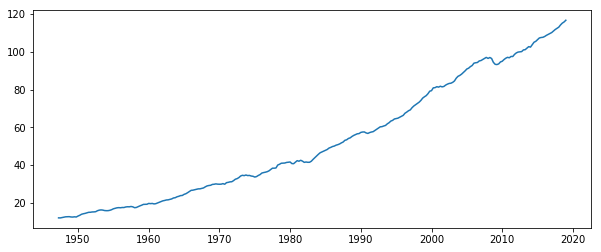

In [35]:
# Plot line plots to see the gdp trend
plt.figure(figsize=(10,4))

plt.plot('time','gdp_quarterly' ,data = merge_47_19_ud)

- As seen from the above chart, since 1947, the real GDP growth rate has almost reached 1200%. There was a sharp decline in 2009. The contraction was due to the financial crisis that began in the United States and then triggered a worldwide economic recession.

## ACF & PACF

I planned to use the ARIMA model to make the prediction, thus; I used the autocorrelation function(ACF) and partial autocorrelation function(PACF) plots to determine the q and p values. ACF is the autocorrelation of k lags related to the values that are k intervals apart. PACF is the autocorrelation of k lags with 0th-lag directly, which is not affected from 1st-lag to (k-1)th-lag. From the slowly decaying ACF plot, I can see that the future values of GDP are heavily affected by past value. With the geometric ACF and significant first lag of PACF, I can use both the AR(1) model and the ARIMA(1,0,0) model.

In [36]:
# Select the time and
df_merge = merge_47_19_ud[['time','gdp_quarterly']]

In [37]:
# Reverse the data frame upside down
df = df_merge.sort_values('time')

In [38]:
# Reset the index of df 
df = df.set_index('time')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1947-04-01 to 2019-01-01
Data columns (total 1 columns):
gdp_quarterly    288 non-null float64
dtypes: float64(1)
memory usage: 4.5 KB


In [40]:
# Check the data
df.head()

,gdp_quarterly
time,
1947-04-01,11.992012
1947-07-01,11.967300
1947-10-01,12.157468
1948-01-01,12.343141
1948-04-01,12.550303


In [41]:
# I want the lags to be equal to the year
2019-1947

72

In [42]:
# Check the autocorrelation for each quarter
df['gdp_quarterly'].autocorr()

0.9999181645941542

In [43]:
# Check the autocorrelation for each year
df['gdp_quarterly'].autocorr(4)

0.9993776461532826

In [44]:
# import the acf and pacf ploting packages
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

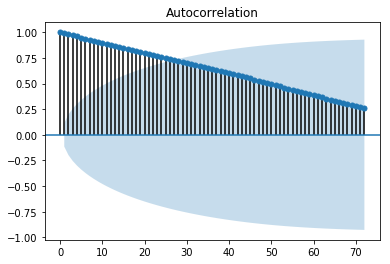

In [45]:
# ACF plot
plot_acf(df, lags = 72 );

- The ACF plot above shows the good positive correlation with the lags up to 27; this is the point where the lag cuts into the confidence threshold. Although we have good correlation up to 27th lag, we cannot use all of them as it will create the multicollinearity problem, that’s why we turn to PACF plot to get only the most relevant lags.

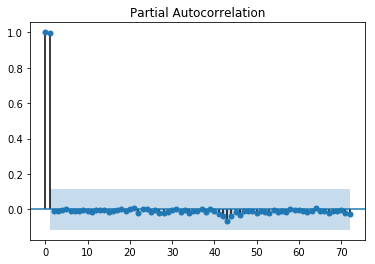

In [46]:
# PACF plot
plot_pacf(df,lags=72);

- In the above plot, we can see that only the first lag have good correlation before the plot first cuts the upper confidence interval. This is our p-value i.e. the order of our AR process. We can use the AR(1) or ARIMA(1,0,0) model to predict.

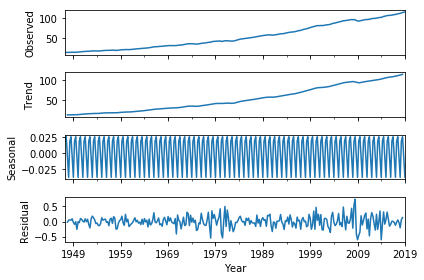

In [47]:
# import the seasonal_decompose package
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(df['gdp_quarterly'], model='additive')
decomposed.plot() 
plt.xlabel('Year');

- We can see that the seasonality information extracted from the series seems reasonable. The residuals are also interesting, showing periods of high variability in the early and later years of the series.

# Time Series Models<a nema='time-series-model'></a>

There are several time series models, and the most common one is ARIMA. Before using the ARIMA model, I need to know is the data stationary or not. The (simplified) definition of a stationary process is that the mean and variance of the process are constant. We can use two methods to test stationary. The first test is to see the trend of rolling mean and rolling standard deviation. I set the rolling window to be equal to 4 so I can get the annual data. If the mean and standard deviation shown as a constant, then the data is stationary. On the other hands, it's not stationary. The second test is the Dicky-Fuller Test, I can import the package to run the test. The results showed the test statistic, p-value, the number of lags used, the number of observation used, the critical value of 1%, 5%, and 10%. 

I already know the p and q value from the ACF and PACF. Then, from the decompose plot, I know that the data can be seasonal and stationary. However, because of the limitations of ARIMA when it comes to seasonal data, I will use SARIMAX model instead. The SARIMAX is the extension of ARIMA that explicitly models the seasonal element in univariate data.

I also considered using Simple Exponential Smoothing (SES) and Holt-Winters’ Method. SES is a reweighed model which weighted the latest data heavier and the oldest data lighter. It is a good choice for forecasting data with no clear trend or seasonal pattern. But the GDP data had the seasonal pattern, I won't use SES. Holt-Winters’ Method is suitable for data with trends and seasonalities which includes a seasonality smoothing parameter γ.

### Mean and Standard Deviation Test.

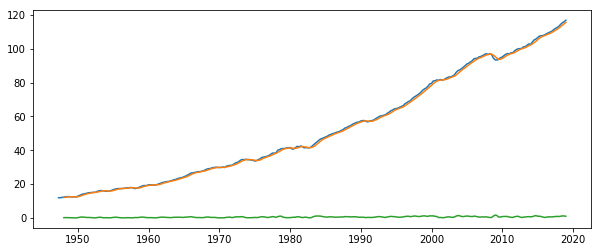

In [48]:
# Plot the line plot for rolling mean and std to see is the data stationary or not.
plt.figure(figsize=(10,4))
plt.plot(df.index,df,
         label = 'Quarterly GDP')
plt.plot(df.index,df.rolling(4).mean(),
         label = 'Annually GDP')
plt.plot(df.index,df.rolling(4).std(),
         label = 'Annually GDP')

Based on the above line charts, we can see that the mean change over time, which means that the process is nonstationary. 

### Dicky-Fuller Test

In [49]:
# Import Dicky-Fuller package
from statsmodels.tsa.stattools import adfuller

def dicky_fuller(dataframe):
    # Use Dicky-Fuller Test to see if the data is stationary
    print('Result of Dicky-Fuller Test')
    dicky = adfuller(dataframe['gdp_quarterly'])

    # Print the result 
    print('Test Statistic: ',dicky[0])
    print('p-value: ',dicky[1])
    print('No. of Lags: ',dicky[2])
    print('No. of Observations: ',dicky[3])
    print('Critical Value(1%): ',dicky[4]['1%'])
    print('Critical Value(5%): ',dicky[4]['5%'])
    print('Critical Value(10%): ',dicky[4]['10%'])

In [50]:
dicky_fuller(df)

Result of Dicky-Fuller Test
Test Statistic:  3.0191985931353194
p-value:  1.0
No. of Lags:  12
No. of Observations:  275
Critical Value(1%):  -3.454355055831705
Critical Value(5%):  -2.8721080938842976
Critical Value(10%):  -2.572401325619835


- The p-value is 0.02278 which is larger than 0.005. That is to say, we cannot reject the null hypothesis which assumed the data is stationary. It leads us to the answer that the data is not stationary.

## AR(1) Model <a name='ar'></a>

### Select 80% of the data as a training set, and the latest 20% data as the testing set.

In [51]:
# import the package
from statsmodels.tsa.arima_model import AR
from sklearn.metrics import mean_squared_error

In [52]:
# See the number of 80% of the data
0.8*len(df)

230.4

In [53]:
# Set the train and test of data
train =  df['gdp_quarterly'][:230]
test = df['gdp_quarterly'][230:]

In [54]:
# initiate model 
ar_model = AR(train)

# Fit model
ar = ar_model.fit(maxlag=1)

# make predictions 
ar_train_pred = ar.predict(start= ar.k_ar, 
                            end=len(train))
ar_test_pred = ar.predict(start=len(train), 
                          end=(len(train) + len(test)-1))


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [55]:
def MSE(traindata, testdata, train_pred, test_pred):
    # Test the accuracy of train and test data
    print('Train MSE score:', mean_squared_error(traindata,
                                                 train_pred))
    print('Test MSE score:', mean_squared_error(testdata,
                                                test_pred))
    return

In [56]:
MSE(train, test, ar_train_pred, ar_test_pred)

Train MSE score: 0.1386593561652148
Test MSE score: 181.58886599613416


- The train MSE score is much smaller than the test MSE score which shows the AR(1) model is overfit.  


In [57]:
split_1 = 'Data Split 80% for Training & 20% for Testing'
split_2 = 'Data Split at 2009'

In [58]:
def predict_line_plot( model, traindata,
                      testdata,train_pred,
                      test_pred, split_type):
    # Plot Training Predict
    feature = ['Historical Data','Predicted Data']

    plt.figure(figsize =(8,4))
    plt.plot(traindata.index, traindata)
    plt.plot(traindata.index, train_pred)
    # Set labels.
    plt.xlabel('Year')
    plt.ylabel('GDP(Million Dollars)')
    title ='Predicted v.s. Historical GDP(Training)-'+model+'\n'+split_type
    plt.title(title)
    plt.legend(labels = feature)
    
    # Plot Testing Predict
    plt.figure(figsize =(8,4))
    plt.plot(testdata.index, testdata)
    plt.plot(testdata.index, test_pred)
    # Set labels.
    plt.xlabel('Year')
    plt.ylabel('GDP(Million Dollars)')
    title ='Predicted v.s. Historical GDP(Testing)-'+model+'\n'+split_type
    plt.title(title)
    plt.legend(labels = feature)
    return;

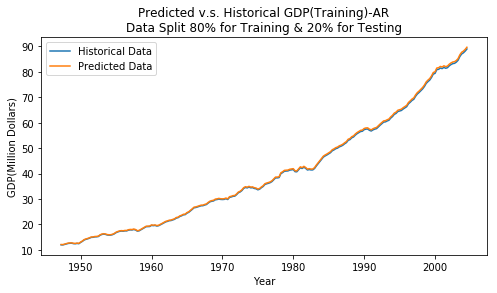

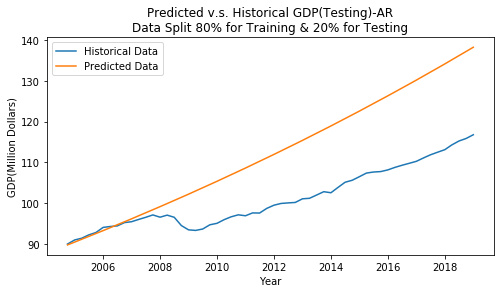

In [59]:
predict_line_plot("AR", train, test, ar_train_pred,
                  ar_test_pred, split_1)

- The above plot shows that the prediction has a significant change start from 2008. The drop in 2009 is the biggest economic crisis around the world in the 21st century. The model doesn’t predict the drop successfully, which causes the overfit. 

### Selected the year 2009 as the critical point to split the data and built models.

Because of the plot above, my theory was the trend of GDP remaining the same if we skip the Great Recession year. Thus, I selected the first quarter of 2009 as the start point of the testing set. The result of new data is totally different compared with the old one. It made the model became much more accurate.

In [60]:
# Select the year 2009 to split  
df['2009']

,gdp_quarterly
time,
2009-01-01,93.403244
2009-04-01,93.268946
2009-07-01,93.609790
2009-10-01,94.649404


In [61]:
# Set the train and test of data
train_2 =  df['gdp_quarterly'][:'2009-10-01']
test_2 = df['gdp_quarterly']['2010-01-01':]

In [62]:
# Check the shape of train and test
print('Train shape' , train_2.shape)
print('Test shape' , test_2.shape)

Train shape (251,)
Test shape (37,)


In [63]:
# initiate model 
ar_model = AR(train_2)

# Fit model
ar = ar_model.fit(maxlag=1)

# make predictions 
train_2_predictions = ar.predict(start= ar.k_ar, 
                              end=len(train_2))
test_2_predictions = ar.predict(start=len(train_2), 
                              end=len(train_2) + len(test_2)-1)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [64]:
MSE(train_2, test_2, train_2_predictions, test_2_predictions)

Train MSE score: 0.1212842274098629
Test MSE score: 0.442737046695025


- The train MSE score was smaller than the test MSE score which indicates the AR(1) model was still over-fitting. However, the result was better than split the train and test data 80% and 20%. 

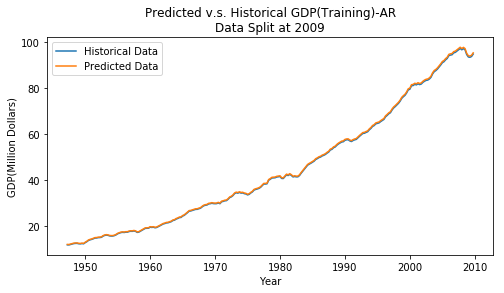

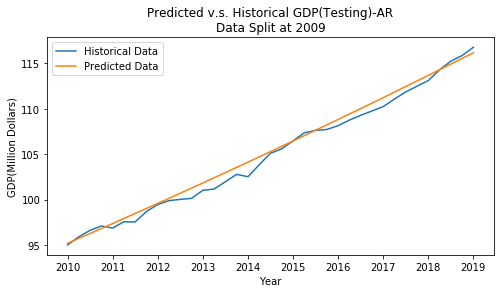

In [65]:
predict_line_plot('AR', train_2, test_2, train_2_predictions,
                  test_2_predictions,split_2)

- The line plot of test set shows the dramatic increase of accuracy of predictions, which told us the GDP is highly autocorrelation of the past value. The trend is remaining upward with a few changes of slope. 

## SARIMAX Model <a name='sarimax'></a>

In [66]:
# Test the best d value.
for d in range(1, len(df['gdp_quarterly'])):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {adfuller(df["gdp_quarterly"].diff(d).dropna())[1]}')
      
    # Check if p < alpha.
    if adfuller(df['gdp_quarterly'].diff(d).dropna())[1] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series.')
        break

Checking difference of 1.
p-value = 8.286943550077044e-11
Differencing our time series by d=1 yields a stationary time series.


### Select 80% of the data as a training set, and the latest 20% data as the testing set.

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Initiate the model
sarimax_model = SARIMAX(train, order =(1,1,0),
                        seasonal_order=(1,1,0,1))

# Fit the model
sarimax = sarimax_model.fit()

# Make prediction 
sarimax_train_pred = sarimax.predict(start= 1, end=len(train))

sarimax_test_pred = sarimax.predict(start= len(train), end=287)

# Get the MSE score
MSE(train, test, sarimax_train_pred,sarimax_test_pred)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


Train MSE score: 0.3586949956207021
Test MSE score: 152.42030794283198


- Compared with the AR model, both the models show the overfit MSE score of, but SARIMAX has better performance.

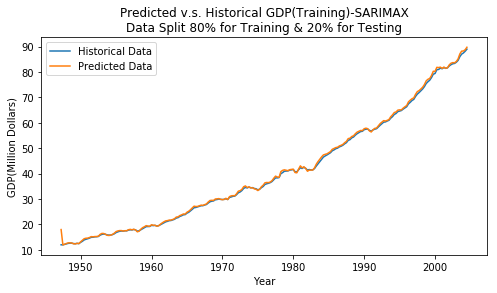

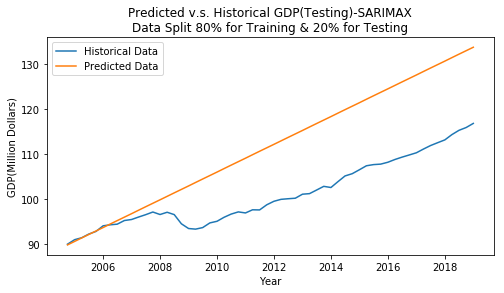

In [68]:
predict_line_plot('SARIMAX',train, test, sarimax_train_pred,
                  sarimax_test_pred,split_1)

### Selected the year 2009 as the critical point to split the data and built models.

In [69]:
# Initiate the model
sarimax_model = SARIMAX(train_2, order =(1,1,0),
                        seasonal_order=(1,1,0,1))

# Fit the model
sarimax = sarimax_model.fit()

# Make prediction 
sarimax_train_2_pred = sarimax.predict(start= 1, end=len(train_2))

sarimax_test_2_pred = sarimax.predict(start= len(train_2), end=287)

# Get the MSE score
MSE(train_2, test_2, sarimax_train_2_pred, sarimax_test_2_pred)

Train MSE score: 0.3715295262682373
Test MSE score: 26.263851576392184


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


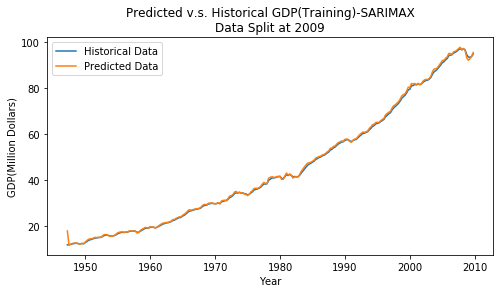

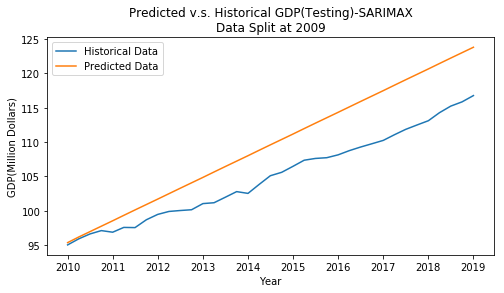

In [70]:
predict_line_plot('SARIMAX',train_2, test_2, sarimax_train_2_pred,
                  sarimax_test_2_pred,split_2)

- The SARIMAX model showed a better performance when I split the data at 2009-01-01.

## Holt-Winter's Method<a name='holt-winter'></a>

In [71]:
# import exponential smoothing
from statsmodels.tsa.api import ExponentialSmoothing

### Select 80% of the data as a training set, and the latest 20% data as the testing set.

In [72]:
# Initiate the model
exp_add_model = ExponentialSmoothing(train, seasonal_periods=4,
                                     trend='add', seasonal='add')
# Fit the model
exp_add = exp_add_model.fit(use_boxcox=True)

# Make prediction
exp_add_train_pred = exp_add.predict(start = 1,
                                     end = len(train))
exp_add_test_pred = exp_add.predict(start = len(train),
                                    end = len(train)+len(test)-1)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [73]:
# Get the MSE score 
MSE(train, test, exp_add_train_pred, exp_add_test_pred)

Train MSE score: 0.14993485180673188
Test MSE score: 161.34481256272343


- Holt-Winter’s method showed the middle MSE performance compared with the AR model and the SARIMAX model.  

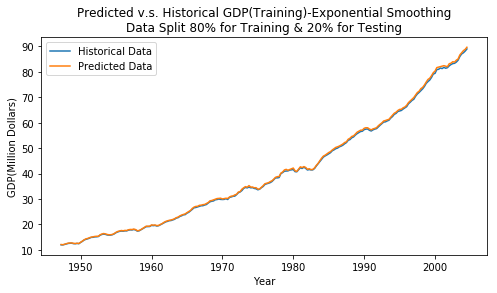

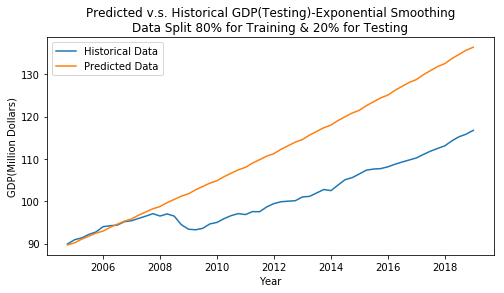

In [74]:
predict_line_plot('Exponential Smoothing',train, test, exp_add_train_pred,
                  exp_add_test_pred, split_1)

### Selected the year 2009 as the critical point to split the data and built models.

In [75]:
# Initiate the model
exp_add_model = ExponentialSmoothing(train_2, seasonal_periods=4,
                                     trend='add', seasonal='add')
# Fit the model
exp_add = exp_add_model.fit(use_boxcox=True)

# Make prediction
exp_add_train_2_pred = exp_add.predict(start = 1,
                                     end = len(train_2))
exp_add_test_2_pred = exp_add.predict(start = len(train_2),
                                    end = len(train_2)+len(test_2)-1)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [76]:
# Get the MSE score 
MSE(train_2, test_2, exp_add_train_2_pred, exp_add_test_2_pred)

Train MSE score: 0.1731125269375432
Test MSE score: 17.860917598653565


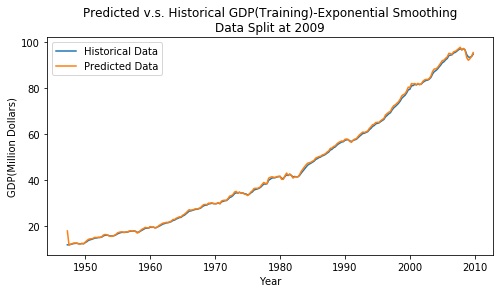

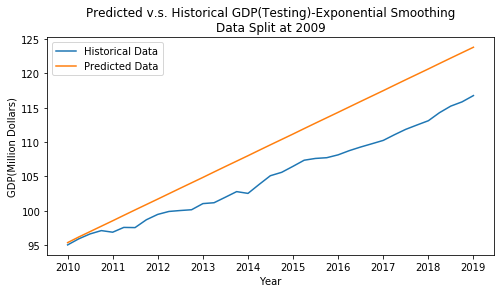

In [77]:
predict_line_plot('Exponential Smoothing',train_2, test_2, sarimax_train_2_pred,
                  sarimax_test_2_pred,split_2)

- The Holt-Winter's shows the middle level of accuracy in all the three models. 

# Conclusion <a name='conclusion'></a>

First of all, the real GDP growth has been over 1200% since 1949. The huge decline in 2009 was because of the financial crisis that began in the United States and the global economic recession that caused the world’s economic recession. Second, the dropped of the GDP in 2009 is nonpredictable by only the historical GDP data. After I set the testing data to start in the first quarter of 2009, all models have a momentous increase in prediction accuracy. Finally, the best model is the AR model with a testing set split in the first quarter of 2009. It has the train MSE score as 0.1212842274098629 and the test MSE score as 0.442737046695025 which make it become a slightly overfit but acceptable model.

# Future Improvement <a name='future-improve'></a>

Studying more time series models and seeing what else I can use to improve the MSE score.

# Resource <a name='resource'> </a>

- GDP: 
    - BEA: https://apps.bea.gov/iTable/iTable.cfm?reqid=19&step=2#reqid=19&step=2&isuri=1&1921=survey
    - OECD: https://stats.oecd.org/index.aspx?queryid=350
- Economic drop: 
    - https://www.marketwatch.com/story/us-exports-fall-in-2015-for-first-time-since-recession-2016-02-05
    - https://www.forbes.com/2009/01/14/global-recession-2009-oped-cx_nr_0115roubini.html#49d387e5185f
- Model:
    - https://www.youtube.com/watch?v=e8Yw4alG16Q
    - https://www.biaodianfu.com/acf-pacf.html
    - https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
    - https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
    - https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1